<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/WEIPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ドローン画像からのキクイモの表現型定量

<img width=50% src="https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/imgs/weips_fig1.png?raw=1">

Guo and Fukano et al.,より

## ライセンス
- Guo, W., Fukano, Y., Noshita, K., & Ninomiya, S. (2020). Field-based individual plant phenotyping of herbaceous species by unmanned aerial vehicle. Ecology and Evolution, 10(21), 12318–12326. https://doi.org/10.1002/ece3.6861
    - CC-BY 4.0
- 公式レポジトリ
    - https://github.com/oceam/WEIPS
    - MIT
- 本稿プログラムコード
    - CC-BY-NC

## 解説
このセクションでは、ドローン（UAV: Unmanned Aerial Vehicle）から得られた画像データを利用した作物の表現型定量技術の一例を紹介します。東京大学の郭と深野らは、ドローン撮影画像から得られたRGBモザイク画像とデジタルサーフィスモデル（DSM: Digital Surface Model）の情報を利用し、圃場から雑草ノイズを排除しつつ、目的とする作物のみの表現型を定量するWEIPS（Weed Elimination for Individual Plant Segmentation）と呼ばれる技術を提唱しています。この技術では、RGB画像から得られるLAB色空間情報およびDSMの高さ情報の2つを利用しています。

解析フロー
1. ドローンによるRGBイメージ撮影
2. Pix4Dmapperソフトウェアによる点群再構成およびDSM生成
3. ArcGISソフトウェアのfishnet機能を利用した作物の位置情報の手動アノテーション
4. WEIPSアルゴリズムによる表現型抽出

本章では、ステップ4のアルゴリズムをPythonで再実装したコードをもとに解説します。ステップ1〜3に興味のある方は、関連文献またはリンクされたリソースを参照してください。

## 備考
公式のコードはMATLABで書かれています。本章ではPython言語で再実装したコードを掲載しますが、同一の関数やクラスがないこと、また掲載にあたり一部の計算を簡略化しているため、公式の結果と若干異なることがあります。

## 環境設定

In [ ]:
# https://datadryad.org/stash/dataset/doi:10.5061/dryad.0cfxpnw0b  # original link
!wget -O weips.zip https://figshare.com/ndownloader/files/43019002  # mirror
!unzip weips.zip

必要なライブラリをインストール・インポートします。

In [ ]:
!pip install rasterio
!pip install geopandas

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import cv2
import rasterio
import glob
from rasterio.transform import from_bounds
import os
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops, block_reduce


## データセットの確認

データセットにはRGBモザイク画像とDSM画像が撮影日ごとにセットで含まれています。RGB画像のみ表示してみましょう。

9


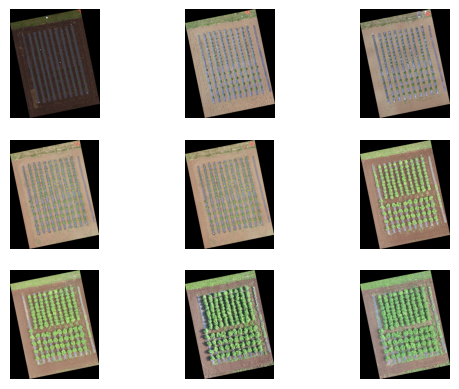

In [32]:
paths = glob.glob("weips/2019tanashi_fukano5all_AP/*/*.tif")
paths = [x for x in paths if x.find("dsm")==-1]
paths = sorted(paths)
print(len(paths))  #9

for i, path in enumerate(paths):
    plt.subplot(3,3,i+1)
    image = cv2.imread(path)[...,::-1]
    image = cv2.resize(image, dsize=None, fx=1/16, fy=1/16)
    plt.imshow(image)
    plt.axis("off")

## Step by Step解説

本稿では、１対のRGBモザイク画像とDSMデータを例に解説します。これらは圃場で撮影されたドローン画像をもとにPix4Dmapperソフトウェアで処理され、生成されたものです。

### RGBモザイク画像とDMSの読み込み

In [4]:
rgb_file_path = "weips/2019tanashi_fukano5all_AP/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m_transparent_mosaic_group1.tif"
dsm_file_path = "weips/2019tanashi_fukano5all_AP/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m_dsm.tif"

with rasterio.open(rgb_file_path) as tif_image:
    rgba = tif_image.read().transpose(1,2,0)
    rgb = rgba[:,:,:3]
with rasterio.open(dsm_file_path) as tif_image:
    dsm = tif_image.read(1)
    # 座標変換に必要な情報を取得します。後に使います。
    transform = from_bounds(*tif_image.bounds, tif_image.width, tif_image.height)

可視化のためにダウンサンプリングをします

In [5]:

rgb_ds = block_reduce(rgb, (20,20,1), np.mean)
dsm_ds = block_reduce(dsm, (20,20), np.mean)

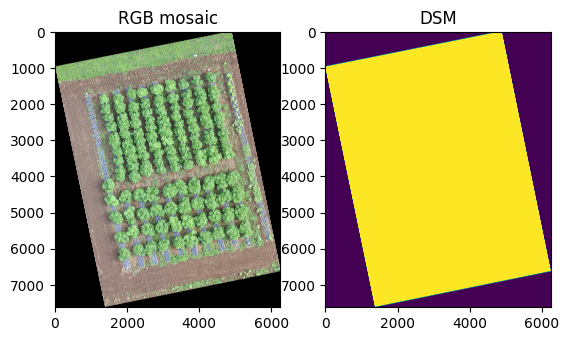

In [6]:
plt.subplot(1,2,1)
plt.title("RGB mosaic")
plt.imshow(rgb)
plt.subplot(1,2,2)
plt.title("DSM")
plt.imshow(dsm)
plt.show()

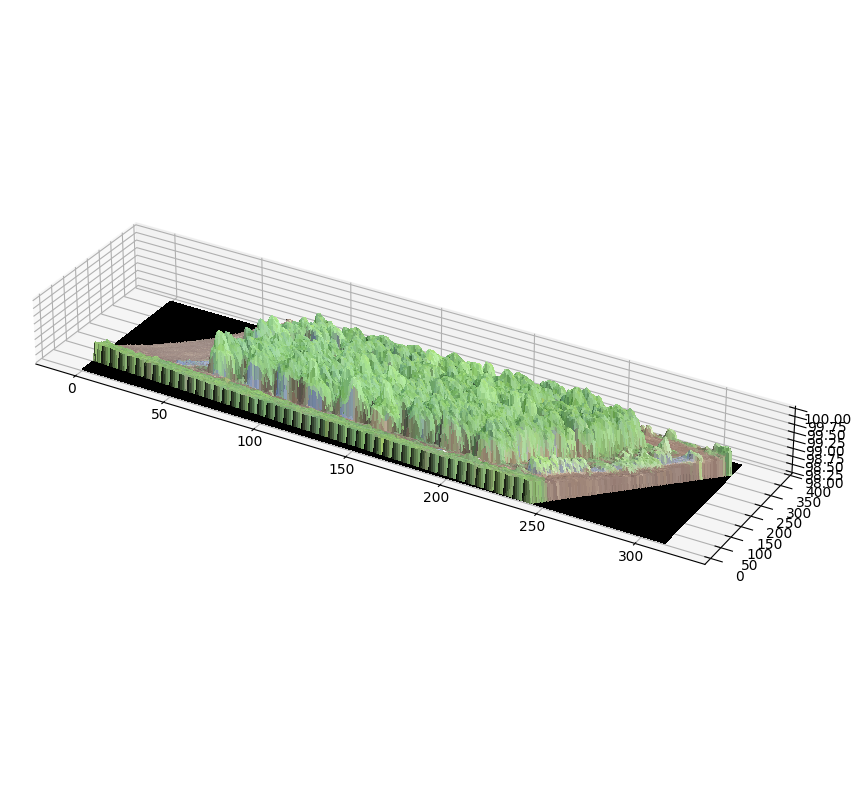

In [7]:
# 3D可視化
x = np.arange(0, dsm_ds.shape[1])
y = np.arange(0, dsm_ds.shape[0])
X, Y = np.meshgrid(x, y)

rgb_ds_norm = rgb_ds / 255.0

lower_limit = 98
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, np.clip(dsm_ds, lower_limit, dsm_ds.max()),
                facecolors=rgb_ds_norm, rstride=1, cstride=1,
                linewidth=0, antialiased=False, shade=False
                )
ax.set_zlim(bottom=lower_limit)
ax.set_box_aspect([1, 0.25, 0.1])
plt.show()

### 座標変換

あらかじめ作物の位置が定義されたshpファイルから座標を抽出します。

In [8]:
# geopandasを用いて作物の位置を記録したshpファイルを読み込みます。
SHAPE_FILE_PATH = "weips/GIS/field1plot.shp"
shapefile = gpd.read_file(SHAPE_FILE_PATH)
# １作物につき１行で表されたデータが取得できます。
print(shapefile)
# 作物はそれぞれ四角形のpolygonで表現されています。
# ただし、closedなpolygonを表現するため、最初の点と最後の点が同じ座標になっており、実際には5座標で表現されています。
print(shapefile.geometry[0])

    Id          Plot                                           geometry
0    0         T25-4  POLYGON ((367908.214 3955465.214, 367906.645 3...
1    0  T25-3/T28-10  POLYGON ((367909.743 3955465.498, 367908.173 3...
2    0         T28-9  POLYGON ((367911.260 3955465.775, 367909.690 3...
3    0         C26-2  POLYGON ((367908.015 3955466.142, 367906.446 3...
4    0         C27-2  POLYGON ((367912.782 3955466.103, 367911.213 3...
..  ..           ...                                                ...
85   0          G2-3  POLYGON ((367913.830 3955475.820, 367912.260 3...
86   0         C11-1  POLYGON ((367918.823 3955475.576, 367917.254 3...
87   0          C1-5  POLYGON ((367915.380 3955476.079, 367913.810 3...
88   0     C1-1/C1-2  POLYGON ((367916.985 3955476.433, 367915.416 3...
89   0          C1-3  POLYGON ((367918.554 3955476.798, 367916.984 3...

[90 rows x 3 columns]
POLYGON ((367908.2140206621 3955465.213946267, 367906.64459916134 3955464.843846083, 367906.4066462775 3955465.85

In [9]:
# geopandasの座標は緯度経度で表現されており、このままでは画像の座標と一致しません。
# そこで、rasterioのtransformを用いて座標変換を行います。
converted_coords = []
for geom in shapefile.geometry:
    converted_coord = []
    coords = list(geom.exterior.coords).copy()
    for coord in coords:
        y, x = rasterio.transform.rowcol(transform, coord[0], coord[1])
        converted_coord.append([x,y])
    converted_coords.append(converted_coord)

print(converted_coords)

[[[2054, 4130], [1679, 4219], [1622, 3978], [1997, 3890], [2054, 4130]], [[2418, 4062], [2044, 4151], [1987, 3910], [2362, 3822], [2418, 4062]], [[2780, 3997], [2406, 4085], [2349, 3844], [2724, 3756], [2780, 3997]], [[2006, 3909], [1632, 3997], [1575, 3756], [1949, 3668], [2006, 3909]], [[3144, 3918], [2769, 4006], [2713, 3766], [3087, 3677], [3144, 3918]], [[2363, 3838], [1989, 3926], [1932, 3685], [2307, 3597], [2363, 3838]], [[3507, 3852], [3133, 3940], [3076, 3700], [3450, 3611], [3507, 3852]], [[2727, 3774], [2353, 3862], [2296, 3622], [2671, 3533], [2727, 3774]], [[3905, 3765], [3530, 3854], [3473, 3613], [3848, 3525], [3905, 3765]], [[1946, 3676], [1571, 3765], [1514, 3524], [1889, 3435], [1946, 3676]], [[3094, 3685], [2720, 3773], [2663, 3532], [3037, 3444], [3094, 3685]], [[4273, 3679], [3898, 3767], [3842, 3526], [4216, 3438], [4273, 3679]], [[2312, 3614], [1937, 3703], [1881, 3462], [2255, 3374], [2312, 3614]], [[3455, 3625], [3081, 3713], [3024, 3472], [3399, 3384], [3455,

得られた座標をもとに、RGBモザイク画像上に作物の位置をプロットします。

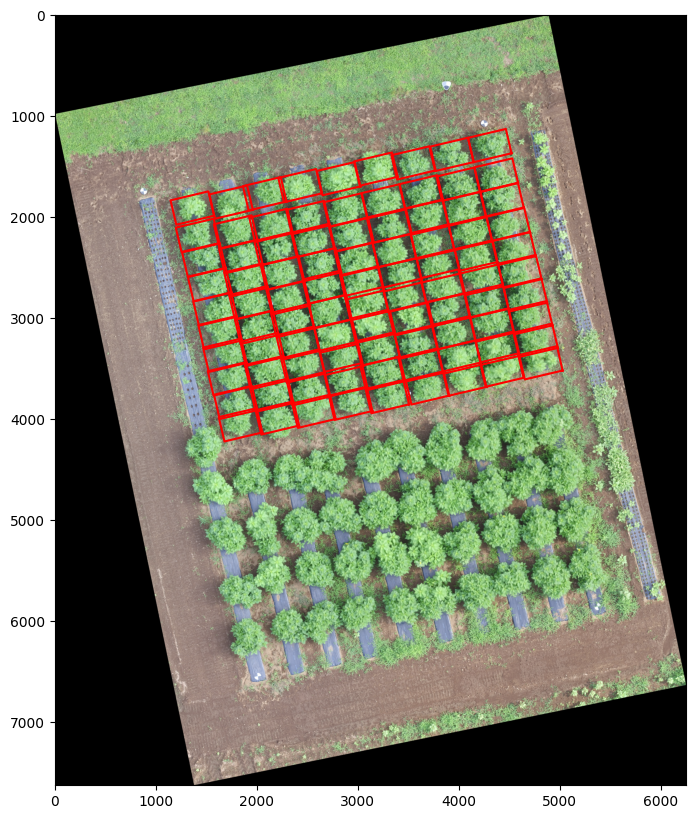

In [10]:
# 作物の位置を可視化してみます。
plt.figure(figsize=(10,10))
plt.imshow(rgb)
for idx, coords in enumerate(converted_coords):
    p1, p2, p3, p4, p5 = coords
    plt.plot([p1[0], p2[0], p3[0], p4[0], p5[0]],
                [p1[1], p2[1], p3[1], p4[1], p5[1]],
                color='red')

### 画像とポリゴンの回転
作物の切り抜きを容易にするため、ここのpolygon四角形の短軸方向が垂直（≒長軸方向が水平）になるように回転します。

In [11]:
# 最初のboundingboxの情報から回転すべき角度を計算します。
p1, p2, p3, p4, _ = converted_coords[0]

points = np.array([p1,p2,p3,p4])
pt1, pt2 = points[0], points[1]

dx = pt2[0] - pt1[0]
dy = pt2[1] - pt1[1]
angle_radians = np.arctan2(dy, dx)
angle_degrees = np.degrees(angle_radians)
rotation_angle = 0 - angle_degrees

# 実際の回転角度を-90度から90度の間に収めるための処理。
if abs(rotation_angle) > 90:
    rotation_angle = 180 + rotation_angle

print(rotation_angle)

13.351178689149663


In [12]:
# rotation center coordinates
center_float = np.array(rgb.shape[:2][::-1]) / 2.0

# rotation matrix
M = cv2.getRotationMatrix2D(center_float, -rotation_angle, 1.0)

# Rotate
rotated_rgb = cv2.warpAffine(rgb, M, (rgb.shape[1], rgb.shape[0]),
                             flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
rotated_dsm = cv2.warpAffine(dsm, M, (dsm.shape[1], dsm.shape[0]),
                             flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=255)

theta = np.radians(rotation_angle)
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

bboxes = []
for coords in converted_coords:
    p1, p2, p3, p4, _ = coords
    points = np.array([p1,p2,p3,p4])
    rotated_point = np.dot(points - center_float, R.T) + center_float

    # 回転後の四角形が長方形になるよう、最小の矩形を計算します。
    contour = rotated_point.reshape((-1, 1, 2)).astype(np.int32)
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    xmin = np.min(box[:, 0])
    xmax = np.max(box[:, 0])
    ymin = np.min(box[:, 1])
    ymax = np.max(box[:, 1])
    bbox = np.array([xmin, ymin, xmax, ymax], dtype=np.int32)
    bboxes.append(bbox)

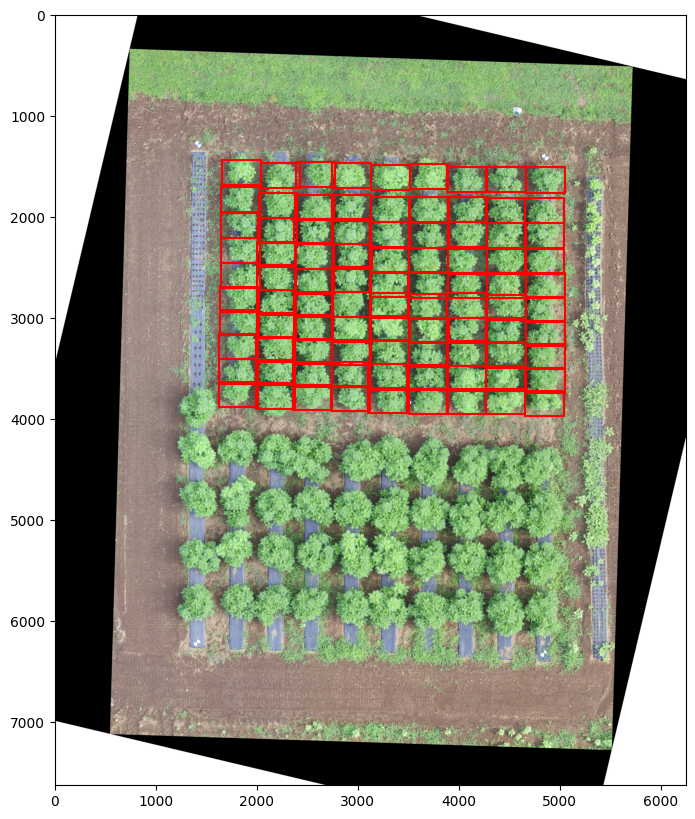

In [13]:
#　改めて可視化します。
plt.figure(figsize=(10,10))
plt.imshow(rotated_rgb)
for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox
    plt.plot([xmin, xmax, xmax, xmin, xmin],
                [ymin, ymin, ymax, ymax, ymin],
                color='red')

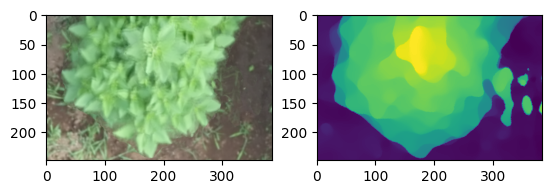

In [14]:
# ようやく、作物の位置を抽出することができました。
# 最初の作物のみを抽出し、表示します。
bbox = bboxes[0]
rgb_crop = rotated_rgb[bbox[1]:bbox[3], bbox[0]:bbox[2]]
dsm_crop = rotated_dsm[bbox[1]:bbox[3], bbox[0]:bbox[2]]
plt.subplot(1,2,1)
plt.imshow(rgb_crop)
plt.subplot(1,2,2)
plt.imshow(dsm_crop)

### WEIPS

WEIPSによる作物の切り抜きを行います。

#### Color Segmentation

色情報を利用して、植物と背景を分離します。
公式レポジトリではmatlabの二分決定木（fitctree）を用いてsegmentation modelを作成しています。
training dataではRGBに加え、LA\*B\*色空間、HSV色空間を利用しています。
matlabでモデルファイルを読み込むと、以下のように表示されます。

```matlab
>> view(DTSMmodel)

分類の決定木
1  A1<-11.0368 の場合はノード 2、A1>=-11.0368 の場合はノード 3、それ以外の場合は background
2  class = vegetation
3  class = background
```

今回のデータセットでは、L\*A\*B色空間のA*成分のみを利用していることがわかりました。
matlabのlab色空間は-127 ~ 128の範囲で表現されているため、以下の式でopencvのL\*A\*Bがとるレンジ（0~255）に変換します。
```python
matlab_a = -11.0368
a_thresh = ((matlab_a + 128) / 255) * 255
a_thresh = int(a_thresh)
print(a_thresh)
# 116
```

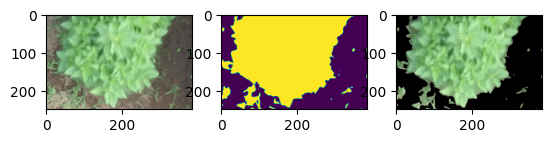

In [15]:
lab_a = cv2.cvtColor(rgb_crop, cv2.COLOR_RGB2LAB)[...,1]
a_mask = lab_a < 116
mask_color = cv2.cvtColor(a_mask.astype(np.uint8)*255, cv2.COLOR_GRAY2BGR)
a_masked = cv2.bitwise_and(rgb_crop, mask_color)
plt.subplot(1,3,1)
plt.imshow(rgb_crop)
plt.subplot(1,3,2)
plt.imshow(a_mask)
plt.subplot(1,3,3)
plt.imshow(a_masked)

### Height Segmentation

DSMから切り出された領域dsm_cropに対して、特定の高さの閾値を設定し、その閾値を超える地点を特定します。
まず、dsm_cropの中で高さが0ではない地点を抽出し、その範囲の最大値と最小値の差（ピークトゥピーク）を計算します。
次に、そのピークトゥピークの値の40%を最小値に加えて閾値を設定し、この閾値よりも高い地点をブール型の配列depth_maskとして取得します。

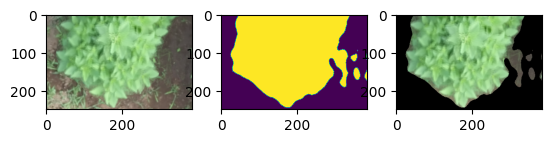

In [16]:
idx_n0 = np.where(dsm_crop != 0)
th_1 = np.ptp(dsm_crop[idx_n0])
thresh = dsm_crop[idx_n0].min() + th_1 * 0.4
depth_mask = dsm_crop > thresh

mask_color = cv2.cvtColor(depth_mask.astype(np.uint8)*255, cv2.COLOR_GRAY2BGR)
depth_masked = cv2.bitwise_and(rgb_crop, mask_color)


plt.subplot(1,3,1)
plt.imshow(rgb_crop)
plt.subplot(1,3,2)
plt.imshow(depth_mask)
plt.subplot(1,3,3)
plt.imshow(depth_masked)

### ColorとHeightの統合
最後に２つのマスクを統合します。２つのマスクの積を取ることで、色と高さの両方の条件を満たす地点を抽出します。

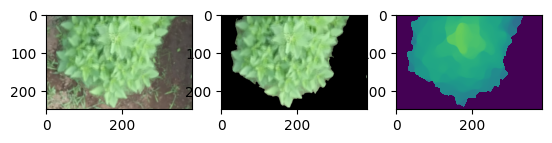

In [17]:
mask = depth_mask & a_mask

mask_color = cv2.cvtColor(mask.astype(np.uint8)*255, cv2.COLOR_GRAY2BGR)
rgb_masked = cv2.bitwise_and(rgb_crop, mask_color)
dsm_masked = np.where(mask, dsm_crop, 0)
plt.subplot(1,3,1)
plt.imshow(rgb_crop)
plt.subplot(1,3,2)
plt.imshow(rgb_masked)
plt.subplot(1,3,3)
plt.imshow(dsm_masked,vmin=98, vmax=100)

これらの情報を利用して、plant (projected) area、coverage_rate、height、volumeなど各種情報を算出することが可能となりました。

## End to End 実装

In [18]:
def calculate_rotation_angle(pt1, pt2):
    dx = pt2[0] - pt1[0]
    dy = pt2[1] - pt1[1]
    angle_radians = np.arctan2(dy, dx)
    angle_degrees = np.degrees(angle_radians)
    rotation_angle = 0 - angle_degrees

    # Determine the optimal (smallest) rotation angle
    if abs(rotation_angle) > 90:
        rotation_angle = 180 + rotation_angle

    return rotation_angle

def rotate_points(points, center, angle_deg):
    # Convert angle to radians
    theta = np.radians(angle_deg)

    # Define the rotation matrix
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    # Subtract the center, rotate, then add the center back
    rotated_points = np.dot(points - center, R.T) + center

    return rotated_points

def approximate_rectangle(points):
    # Convert points to a contour format required by OpenCV
    contour = points.reshape((-1, 1, 2)).astype(np.int32)

    # Approximate the contour to a rectangle
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    xmin = np.min(box[:, 0])
    xmax = np.max(box[:, 0])
    ymin = np.min(box[:, 1])
    ymax = np.max(box[:, 1])
    bbox = np.array([xmin, ymin, xmax, ymax], dtype=np.int32)
    return bbox

def get_file_paths(data_dir, subfolder):
    subfolder_path = os.path.join(data_dir, subfolder)
    files = os.listdir(subfolder_path)
    rgb_file = [x for x in files if x.find("mosaic")>0][0]
    dsm_file = [x for x in files if x.find("dsm")>0][0]
    rgb_file_path = os.path.join(subfolder_path, rgb_file)
    dsm_file_path = os.path.join(subfolder_path, dsm_file)
    return rgb_file_path, dsm_file_path

def get_rgba_dsm_transform(rgb_file_path, dsm_file_path):
    with rasterio.open(rgb_file_path) as tif_image:
        rgba = tif_image.read().transpose(1,2,0)
    with rasterio.open(dsm_file_path) as tif_image:
        dsm = tif_image.read(1)
        transform = from_bounds(*tif_image.bounds, tif_image.width, tif_image.height)
    return rgba, dsm, transform

def convert_coords(shapefile, transform):
    converted_coords = []
    for geom in shapefile.geometry:
        converted_coord = []
        coords = list(geom.exterior.coords).copy()
        for coord in coords:
            y, x = rasterio.transform.rowcol(transform, coord[0], coord[1])
            converted_coord.append([x,y])
        converted_coords.append(converted_coord)
    return converted_coords

def rotate_inputs(converted_coords, rgba, dsm):
    rgb = rgba[...,:3]
    w,h = rgb.shape[1], rgb.shape[0]
    p1, p2, p3, p4, _ = converted_coords[0]
    points = np.array([p1,p2,p3,p4])
    center_float = (float(w/2), float(h/2))

    # Get the rotation matrix
    angle_deg = calculate_rotation_angle(points[0], points[1])
    M = cv2.getRotationMatrix2D(center_float, -angle_deg, 1.0)

    # Rotate
    rotated_rgb = cv2.warpAffine(rgb, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    rotated_dsm = cv2.warpAffine(dsm, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=255)

    # Rotate the points and get the bounding box
    bboxes = []

    for coords in converted_coords:
        p1, p2, p3, p4, _ = coords
        points = np.array([p1,p2,p3,p4])
        rotated_points = rotate_points(points, center_float, angle_deg)
        bbox = approximate_rectangle(rotated_points)
        bboxes.append(bbox)
    return bboxes, rotated_rgb, rotated_dsm


In [19]:
def weips(bboxes, rgb, dsm, vis_bbox_no=0):
    def get_mask_by_depth(cropped_dsm, thresh=0.4):
        idx_n0 = np.where(cropped_dsm != 0)
        th_1 = np.ptp(cropped_dsm[idx_n0])  # ptp computes the range (difference between max and min)
        thresh = cropped_dsm[idx_n0].min() + th_1 * thresh
        depth_mask = cropped_dsm > thresh
        return depth_mask

    def get_mask_by_lab(cropped_rgb, thresh=116):
        a = cv2.cvtColor(cropped_rgb, cv2.COLOR_RGB2LAB)[...,1]
        a_mask = a < 116
        return a_mask

    def get_plant_height(cropped_dsm, mask):
        cropped_dsm = cropped_dsm * mask
        idx_n0 = np.where(cropped_dsm != 0)
        values = cropped_dsm[idx_n0]
        if values.any() !=0:
            plant_height = np.percentile(values, 95)
        else:
            plant_height = np.nan
        return plant_height

    def get_coverage_and_volume(cropped_dsm, mask):
        lbl = label(mask)
        props = regionprops(lbl)
        if len(props) !=0:
            _idx = np.argmax([prop.area for prop in props])
            prop = props[_idx]
            area = prop.area
            coverage_rate = area / (lbl.shape[0] * lbl.shape[1])
            volume = cropped_dsm[prop.coords[:,0], prop.coords[:,1]].sum()
        else:
            coverage_rate = np.nan
            volume = np.nan
        return coverage_rate, volume

    result_list = []
    for i, bbox in enumerate(bboxes):
        result = {}

        cropped_rgb = rgb[bbox[1]:bbox[3], bbox[0]:bbox[2]].copy()
        cropped_dsm = dsm[bbox[1]:bbox[3], bbox[0]:bbox[2]].copy()

        depth_mask = get_mask_by_depth(cropped_dsm)
        lab_mask = get_mask_by_lab(cropped_rgb)
        mask = depth_mask & lab_mask

        plant_height = get_plant_height(cropped_dsm, mask)

        if plant_height != np.nan:
            coverage_rate, volume = get_coverage_and_volume(cropped_dsm, mask)
        else:
            coverage_rate, volume = np.nan, np.nan

        result["bbox_id"] = i
        result["plant_height"] = plant_height
        result["coverage_rate"] = coverage_rate
        result["volume"] = volume
        result_list.append(result)

        if i == vis_bbox_no:
            image = cropped_rgb
            binary_mask_color = cv2.cvtColor(mask.astype(np.uint8)*255, cv2.COLOR_GRAY2BGR)
            masked = cv2.bitwise_and(image, binary_mask_color)
    return result_list, image, masked

def analyze(shape_file_path, data_dir, vis_bbox_no=0):
    # SHAPE_FILE_PATH = "/content/drive/MyDrive/phenotyping_temp_assets/weips/GIS/field1plot.shp"
    # DATA_DIR = "/content/drive/MyDrive/phenotyping_temp_assets/weips/2019tanashi_fukano5all_AP"

    results_list = []
    shapefile = gpd.read_file(shape_file_path)
    subfolders = sorted(os.listdir(data_dir))

    images = []
    processed = []

    for subfolder in subfolders:
        print(subfolder)
        rgb_file_path, dsm_file_path = get_file_paths(data_dir, subfolder)
        rgba, dsm, transform = get_rgba_dsm_transform(rgb_file_path, dsm_file_path)
        converted_coords = convert_coords(shapefile, transform)
        bboxes, rotated_rgb, rotated_dsm = rotate_inputs(converted_coords, rgba, dsm)

        # result["timepoint"] = subfolder.split("_")[3]
        filetime = subfolder.split("_")[3]
        result_list, image, masked = weips(bboxes, rotated_rgb, rotated_dsm, vis_bbox_no=vis_bbox_no)
        result_list = [{**d, "time": filetime} for d in result_list]
        results_list.extend(result_list)

        images.append(image)
        processed.append(masked)

    df = pd.DataFrame(results_list)
    return df, images, processed


SHAPE_FILE_PATH = "weips/GIS/field1plot.shp"
DATA_DIR = "weips/2019tanashi_fukano5all_AP"
df, images, processed = analyze(SHAPE_FILE_PATH, DATA_DIR)

potato_tanashi_8FUKANO_20170516_InsRGB_15m
potato_tanashi_8FUKANO_20170531_Ins1RGB_15m
potato_tanashi_8FUKANO_20170604_Ins1RGB_15m
potato_tanashi_8FUKANO_20170612_Ins1RGB_15m
potato_tanashi_8FUKANO_20170616_Ins1RGB_15m
potato_tanashi_8FUKANO_20170629_Ins1RGB_15m
potato_tanashi_8FUKANO_20170703_Ins1RGB_15m
potato_tanashi_8FUKANO_20170707_Ins1RGB_15m
potato_tanashi_8FUKANO_20170710_Ins1RGB_15m


得られるデータフレームのtime列をdatetime型に変換しておきます。

In [20]:
df["time"] = pd.to_datetime(df["time"])

データフレームの結果を出力します。下のセルの実行を終えると、セル下部にNext steps: View recommended plotsというボタンが表示されます（Colaboratoryの場合）。グラフのコードを書かず、多様な可視化が提案されます。気になるグラフを選択してみてみましょう。必要に応じて提案コードをカスタマイズすることもできます。

In [21]:
df

,bbox_id,plant_height,coverage_rate,volume,time
0,0,98.535469,0.011641,1.297517e+05,2017-05-16
1,1,98.614441,0.027822,3.110424e+05,2017-05-16
2,2,98.632449,0.019416,2.176155e+05,2017-05-16
3,3,98.553665,0.014116,1.567636e+05,2017-05-16
4,4,98.507621,0.012892,1.439705e+05,2017-05-16
...,...,...,...,...,...
805,85,99.844177,0.673953,6.386862e+06,2017-07-10
806,86,99.587952,0.522063,4.959792e+06,2017-07-10
807,87,99.631361,0.615003,5.845240e+06,2017-07-10
808,88,99.720078,0.621731,5.960468e+06,2017-07-10


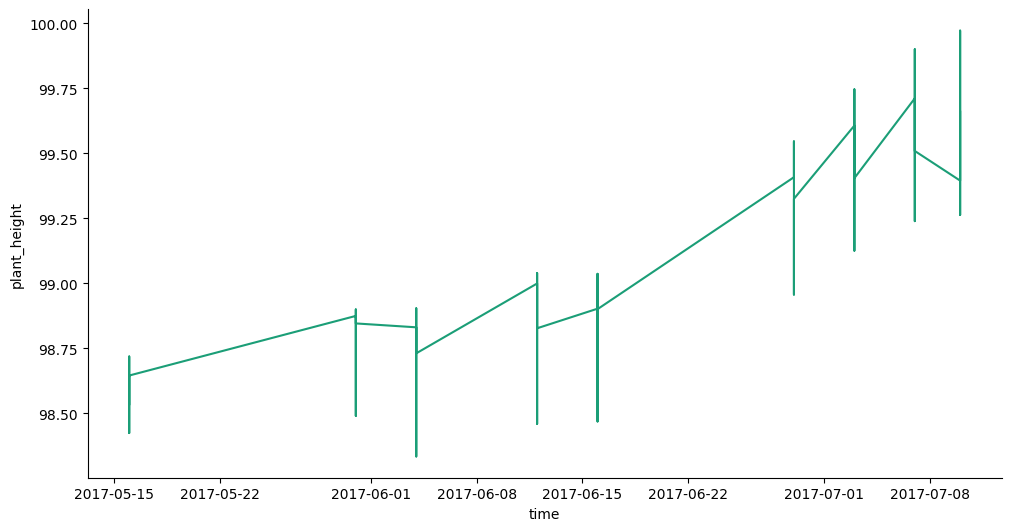

In [ ]:
# @title time vs plant_height

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['plant_height']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('plant_height')

## 最後に
今回の計算では、plant_height（およびvolume）は地面の高さとの差分を計算していないため、不完全です。地面の高さは各cropの情報から産出し、plant heightとの差分を計算することで求めることができます。挑戦してみましょう。